In [1]:
from ellipsx import calc_psi_delta_one_layer_vec, calc_psi_delta_one_layer_roughess_vec

In [2]:
from ellipsx.optim import one_layer_df_nf_lm
from ellipsx.optim import one_layer_df_nf_params_std
from ellipsx.optim import one_layer_roughness_d_nf_lm
from ellipsx.optim import one_layer_roughness_d_nf_params_std

In [3]:
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

In [4]:
import jax
import numpy as np
import jax.numpy as jnp

In [5]:
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

In [6]:
jax.devices()

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [7]:
import matplotlib.pyplot as plt

In [8]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.autolayout'] = True

In [9]:
%matplotlib inline

In [10]:
import optimistix as optx

In [11]:
from jaxtyping import Array, Complex, Float

# Подготовка данных

In [12]:
n = jnp.array([1., 1.462, 3.882 - 0.019j])
d = jnp.array([1., 400, 1])

In [13]:
phi = jnp.linspace(45, 80, 8)

In [14]:
psi, delta = calc_psi_delta_one_layer_vec(phi, n, d[1])
psi_rough, delta_rough = calc_psi_delta_one_layer_roughess_vec(phi, n, d)

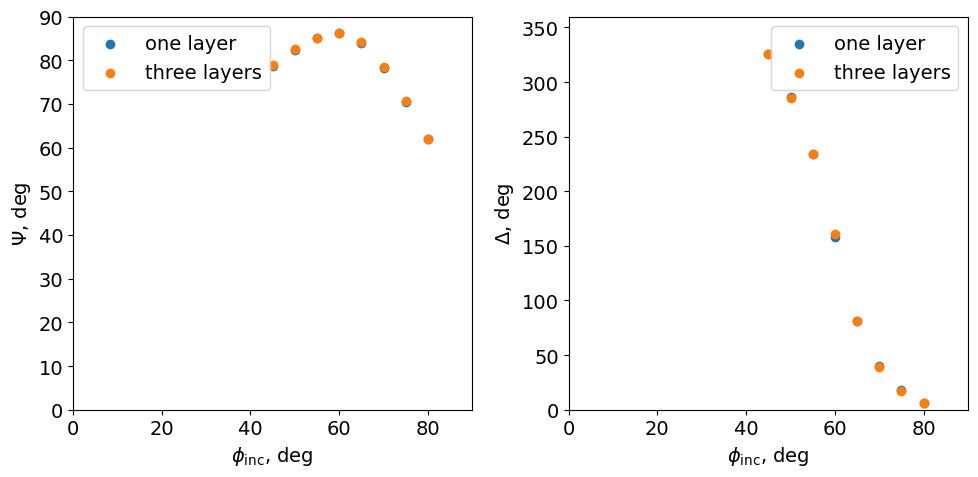

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(phi, psi, label='one layer')
ax1.scatter(phi, psi_rough, label='three layers')
ax2.scatter(phi, delta, label='one layer')
ax2.scatter(phi, delta_rough, label='three layers')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

In [16]:
from jax import random
key = random.key(0)
psi_std = 0.1
delta_std = 0.5

## One layer model

In [17]:
psi1 = psi + psi_std * random.normal(key, shape=psi.shape)
psi1_std = jnp.ones_like(psi1) * psi_std

In [18]:
delta1 = delta + delta_std * random.normal(key, shape=delta.shape)
delta1_std = jnp.ones_like(delta1) * delta_std

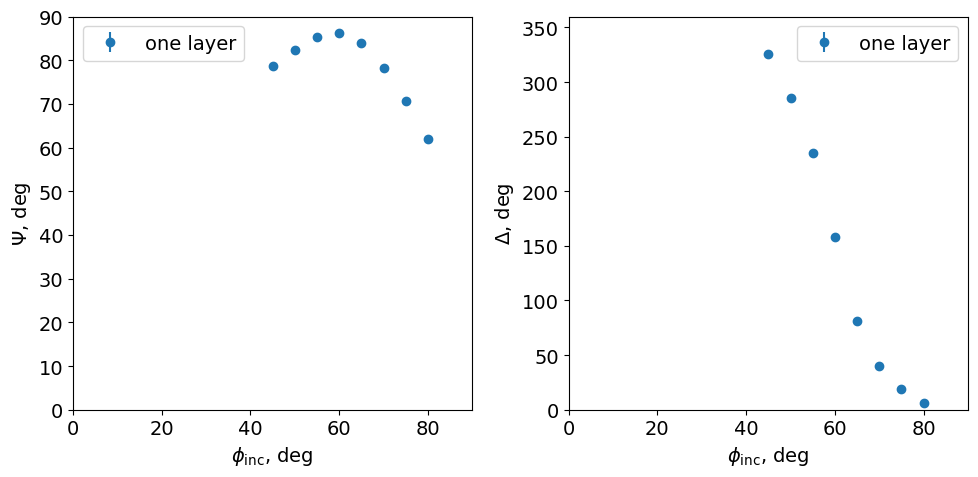

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.errorbar(x=phi, y=psi1, yerr=psi1_std, label='one layer', fmt='o')
ax2.errorbar(x=phi, y=delta1, yerr=delta1_std, label='one layer', fmt='o')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

### Levenberg - Marquardt

In [20]:
params0 = jnp.array([400, 1.46])

In [21]:
data = jnp.stack([phi, psi1, psi1_std, delta1, delta1_std])
n_sub = 3.882 - 1j * 0.019

In [22]:
popt = one_layer_df_nf_lm(data, params0, n_sub)

In [23]:
pstd, pcorr = one_layer_df_nf_params_std(data, popt, n_sub)

In [24]:
print(popt)
print(pstd)

[399.63505512   1.46297354]
[0.44778744 0.00108378]


In [25]:
print(pcorr)

[[ 1.         -0.99643349]
 [-0.99643349  1.        ]]


In [26]:
phi_model = jnp.linspace(0, 90, 100)

In [27]:
n0 = 1.0
n_f = popt[1]

In [28]:
n = jnp.array([n0, n_f, n_sub])

In [29]:
d = popt[0]
wl = 632.8

In [30]:
psi, delta = calc_psi_delta_one_layer_vec(phi_model, n, d, wl)


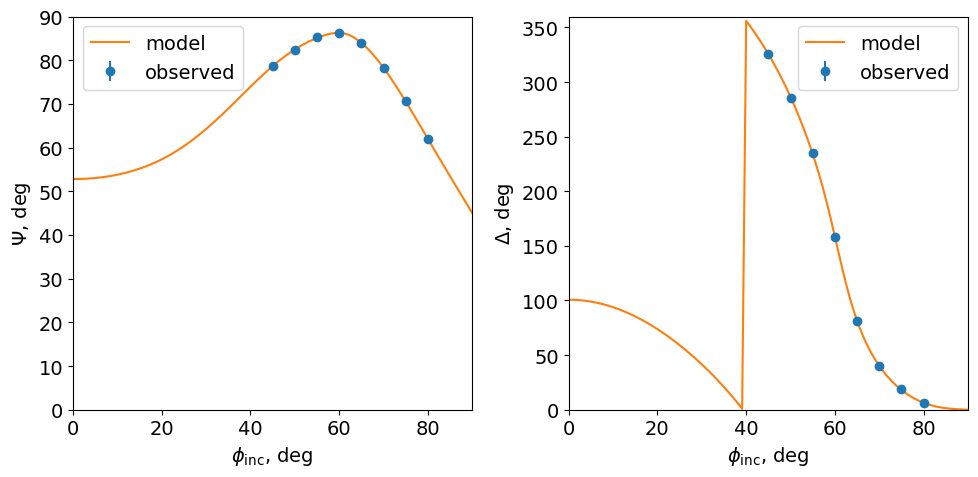

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.errorbar(x=phi, y=psi1, yerr=psi1_std, label='observed', fmt='o')
ax2.errorbar(x=phi, y=delta1, yerr=delta1_std, label='observed', fmt='o')
ax1.plot(phi_model, psi, label='model')
ax2.plot(phi_model, delta, label='model')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

## Three layer model

In [32]:
psi3 = psi_rough + psi_std * random.normal(key, shape=psi_rough.shape)
psi3_std = jnp.ones_like(psi_rough) * psi_std

In [33]:
delta3 = delta_rough + delta_std * random.normal(key, shape=delta_rough.shape)
delta3_std = jnp.ones_like(delta_rough) * delta_std

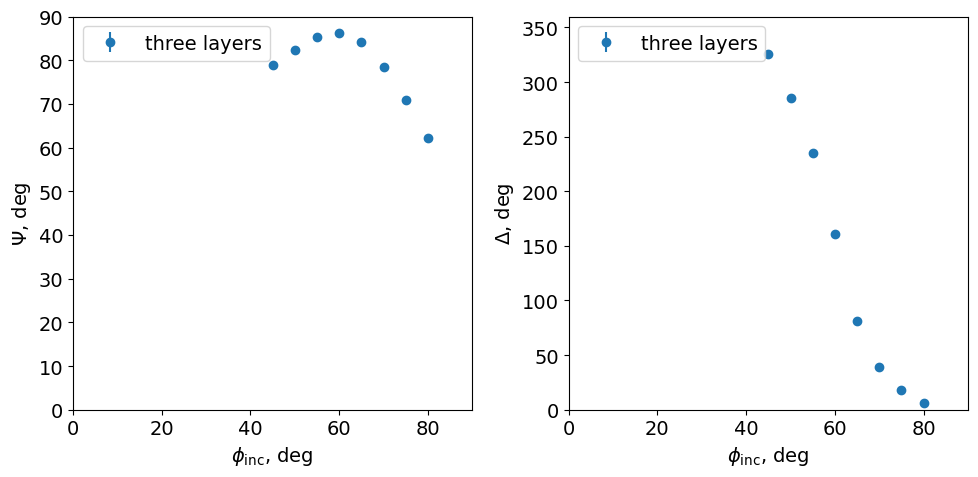

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.errorbar(x=phi, y=psi3, yerr=psi3_std, label='three layers', fmt='o')
ax2.errorbar(x=phi, y=delta3, yerr=delta3_std, label='three layers', fmt='o')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');

### Levenberg - Marquardt

In [52]:
params0 = jnp.array([2, 400, 2, 1.46])

In [53]:
data = jnp.stack([phi, psi3, psi3_std, delta3, delta3_std])
n_sub = 3.882 - 1j* 0.019


In [54]:
popt = one_layer_roughness_d_nf_lm(data, params0, n_sub)

In [58]:
pstd, pcor = one_layer_roughness_d_nf_params_std(data, popt, n_sub)

In [59]:
print(popt)
print(pstd)

[1.53100188e-01 3.99479408e+02 1.12861068e+00 1.46366634e+00]
[1.11761205 0.52289128 0.4931711  0.00125878]


In [60]:
print(pcor)

[[ 1.         -0.1717752  -0.88922183 -0.18010505]
 [-0.1717752   1.          0.38421315 -0.9354977 ]
 [-0.88922183  0.38421315  1.         -0.06783273]
 [-0.18010505 -0.9354977  -0.06783273  1.        ]]


In [65]:
phi_model = jnp.linspace(0, 90, 100)

In [61]:
n0 = 1.
n_f = popt[3]
d = jnp.array([popt[0], popt[1], popt[2]])

In [62]:
n = jnp.array([n0, n_f, n_sub])

In [63]:
psi, delta = calc_psi_delta_one_layer_roughess_vec(phi_model, n, d)


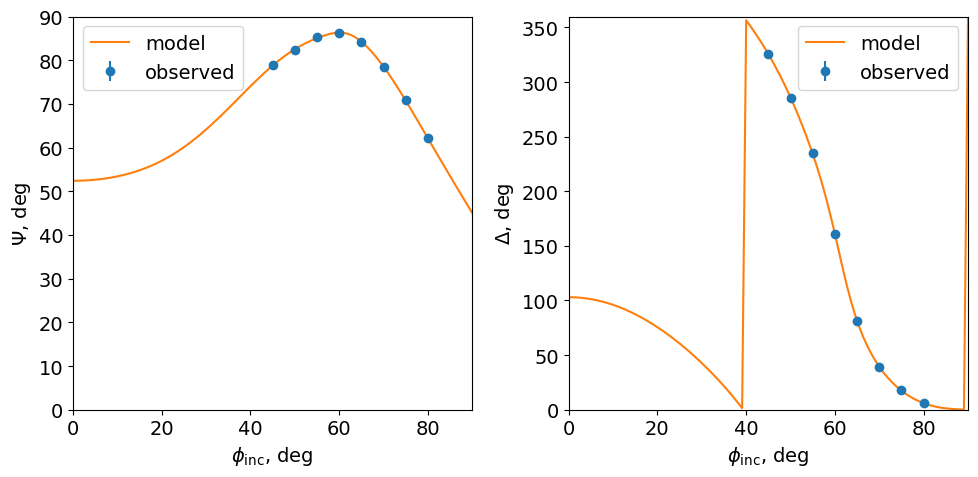

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.errorbar(x=phi, y=psi3, yerr=psi3_std, label='observed', fmt='o')
ax2.errorbar(x=phi, y=delta3, yerr=delta3_std, label='observed', fmt='o')
ax1.plot(phi_model, psi, label='model')
ax2.plot(phi_model, delta, label='model')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
ax1.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax1.set_ylabel(r'$\Psi$, deg')
ax2.set_xlim(0, 90)
ax2.set_ylim(0, 360)
ax2.set_xlabel(r'$\phi_\mathrm{{inc}}$, deg')
ax2.set_ylabel(r'$\Delta$, deg')
ax1.legend(loc='best')
ax2.legend(loc='best');